In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import emcee
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from nbodykit.lab import *
from numpy.linalg import inv
import scipy.integrate as integrate
import math
import scipy.optimize as op
from scipy.optimize import curve_fit
import numpy.linalg as linalg
from multiprocessing import Pool
import tqdm
import h5py

In [3]:
dat = np.loadtxt('../input/PK_EZmock_eBOSS_QSO_NGC_v5_z0.8z2.2_0083.dat')
kdat = dat[:,1]
valid = (kdat >0.01) & (kdat<0.3)
kobs = dat[valid,1]
P0dat = dat[valid,3]
P0s = P0dat.size
P2dat = dat[valid,4]
Pkdata = np.append(P0dat,P2dat)
size = Pkdata.size
half = int(size/2)

In [4]:
cov = np.load('../input/EZmockcovariance_cut.npy')
covinv = inv(cov)
error = np.zeros(size)
for i in range(size):
    error[i] = np.sqrt(1./covinv[i][i])


In [5]:
Ptemp = np.loadtxt('../input/PlanckDM.linear.pk')
ktemp = Ptemp[:,0]
Plintemp = Ptemp[:,1]
print(ktemp.size)
print(ktemp[2900:5500])

10000
[0.00966225 0.00967749 0.00969276 ... 0.57909577 0.58000923 0.58092412]


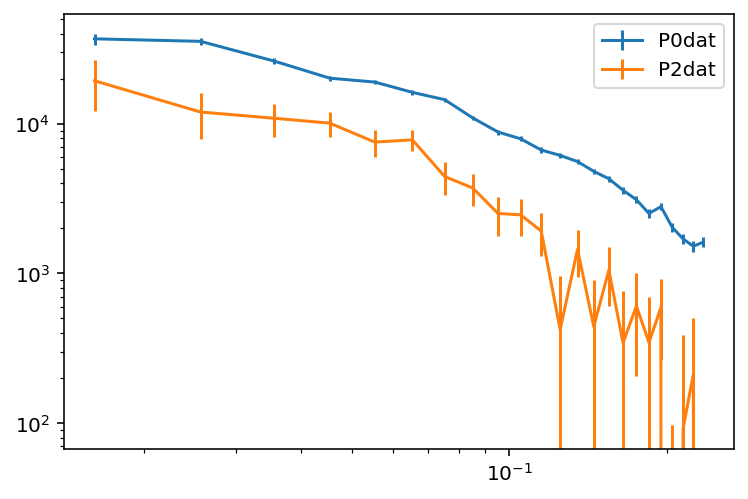

In [6]:
plt.errorbar(kobs,P0dat,label='P0dat',yerr = error[0:half])
plt.errorbar(kobs,P2dat,label='P2dat',yerr = error[half:size])
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')

plt.rcParams['figure.figsize'] = [15, 10]

#This is a plot of the monopole P0 and quadrupole P4 data.  
#The error bars are derived from the digaonals of the covariance matrix

In [7]:
redshift = 1.5
cosmo = cosmology.Cosmology(h=0.6777,Omega0_b=0.048206, n_s=0.9611).match(Omega0_m=0.307115)
Plinfunc = cosmology.LinearPower(cosmo, redshift=redshift, transfer='CLASS')
Psmlinfunc = cosmology.LinearPower(cosmo, redshift=redshift, transfer='NoWiggleEisensteinHu')

In [8]:
muobs = np.linspace(-1,1,100)
sigpar = 8.
sigperp =4.

In [9]:
def polyf(j,k):

    if j==0 or j==5:
        h = 1./k**3
        return h
    if j ==1 or j==6:
        h = 1./k**2
        return h
    if j ==2 or j==7:
        h = 1./k
        return h
    if j==3 or j==8:
        h = 1.
        return h
    if j==4 or j==9:
        h = k
        return h

In [10]:
H = np.zeros((size,10))
for i in range(0,size):
    for j in range(0,5):
        if(i<half):
            H[i][j] = polyf(j,kobs[i])
        if(i>=half):
            H[i][j+5] = polyf(j+5,kobs[i-half])
        
Ht = H.transpose()
print(H.shape)
print(covinv.shape)


(46, 10)
(46, 46)


In [11]:
def polysolve(resmodel):
    C1 = linalg.pinv((np.matmul(Ht,np.matmul(covinv,H))))
    C2 = np.matmul(Ht,np.matmul(covinv,resmodel))
    theta = np.matmul(C1,C2)
    return(theta)

In [12]:
kup = 5900
kdown = 2900
def Psmfitfunopt(k,a1,a2,a3,a4,a5):
    Psmfitpre = Psmlinfunc(ktemp[kdown:kup]) + a1/ktemp[kdown:kup]**3 
    + a2/ktemp[kdown:kup]**2 + a3/ktemp[kdown:kup] + a4 + a5*ktemp[kdown:kup]
    Psmfit = np.interp(k, ktemp[kdown:kup], Psmfitpre)
    return Psmfit

In [13]:
popt,pcov = curve_fit(Psmfitfunopt,ktemp[kdown:kup],Plinfunc(ktemp[kdown:kup]))
asm1 = popt[0]
asm2= popt[1]
asm3 = popt[2]
asm4 = popt[3]
asm5 = popt[4]

/home/ao456/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
def Olin(k):
    Olin = Plinfunc(k)/Psmfit(k)
    return Olin

In [15]:
Psmfitopt = Psmfitfunopt(ktemp[2900:5900],asm1,asm2,asm3,asm4,asm5)

In [16]:
def Psmfit(k):
    Psmfit = np.interp(k,ktemp[2900:5900],Psmfitopt)
    return Psmfit

Text(0.5, 0, 'k [$h \\ \\mathrm{Mpc}^{-1}$]')

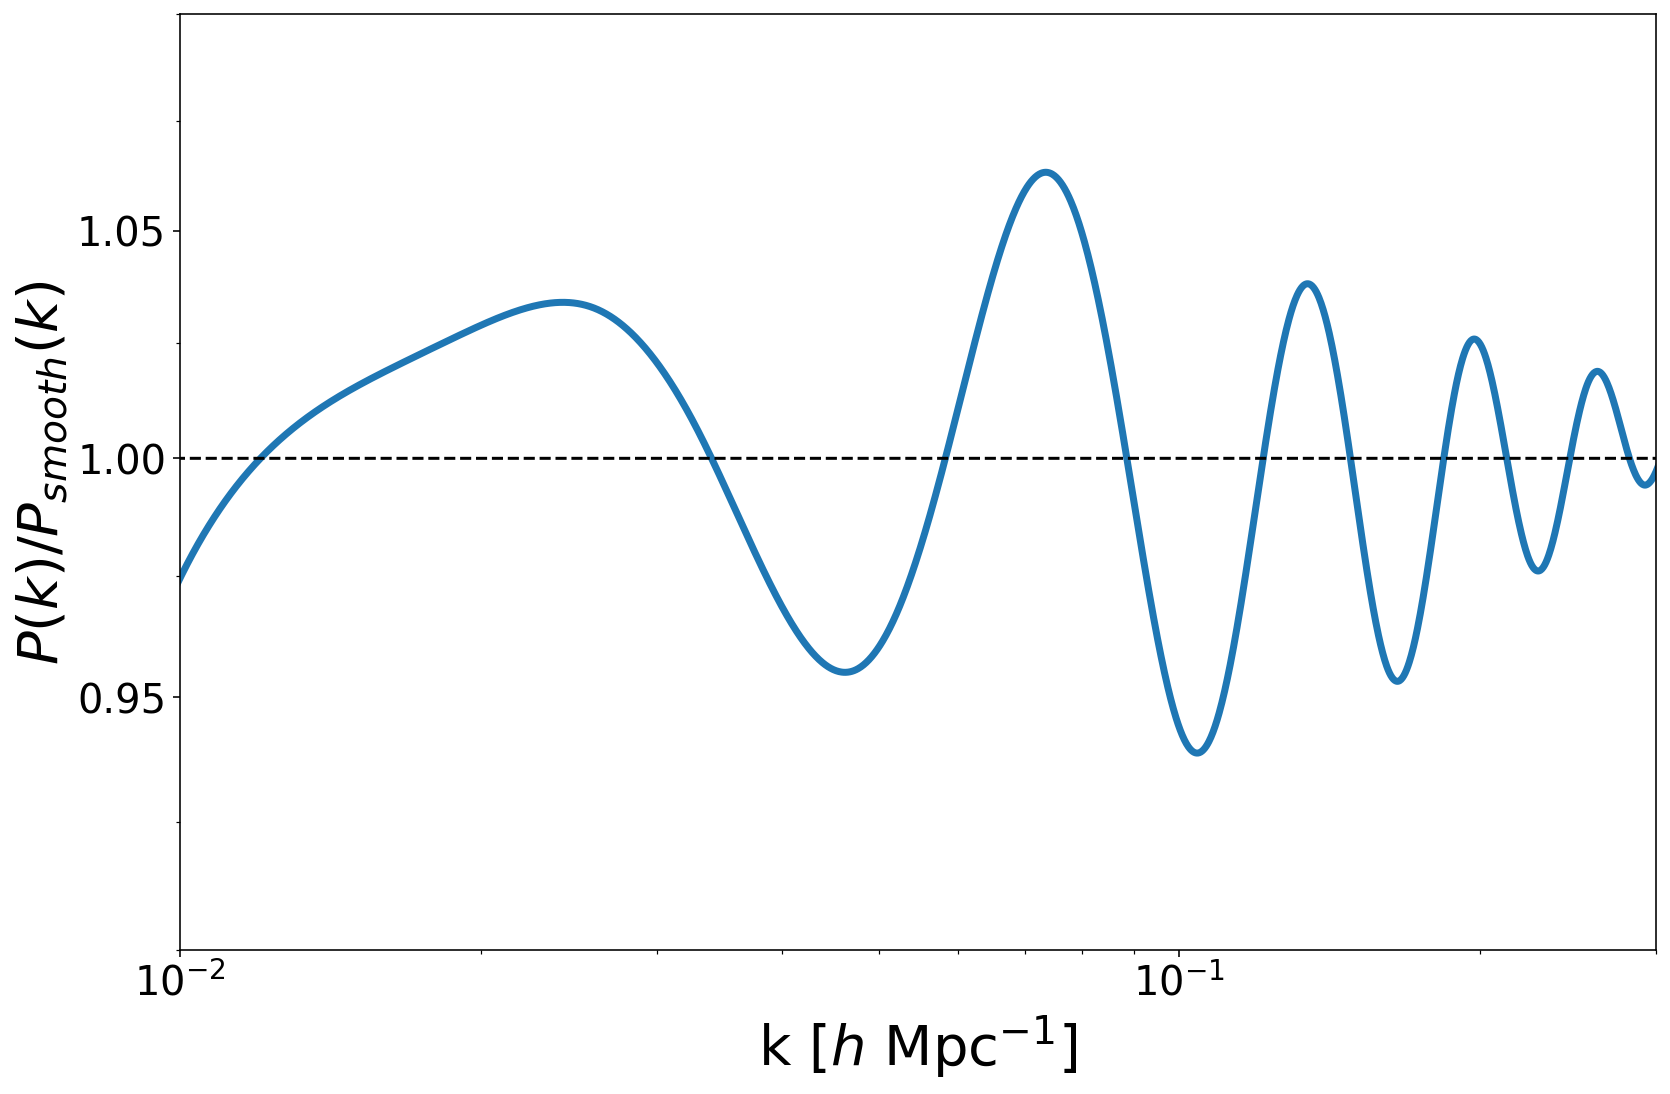

In [17]:
from matplotlib.ticker import ScalarFormatter

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.autolayout': True})

fig1, ax1 = plt.subplots()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_yticks((0.95, 1.0, 1.05))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
#plt.yscale('log')
#plt.xscale('log')
ax1.plot(ktemp,Olin(ktemp),linewidth=3.5,label='Olin')
ax1.plot(ktemp,[1.0]*ktemp.size,'--',color='k')
#plt.legend(loc=0)
plt.xlim(0.01,0.3)
plt.ylim(0.9,1.1)

plt.ylabel(r"$\ P(k)/P_{smooth}(k)$",fontsize=28)
plt.xlabel(r"k [$h \ \mathrm{Mpc}^{-1}$]",fontsize=28)

#This plot shows the BAO wiggles (the Olin function) from linear theory.
#This is incorporated into the model power spectrum
#Florian's paper that describes the entire model: https://arxiv.org/pdf/1607.03149.pdf

In [18]:
class model:

    def __init__(self,params):

        self.B = params[0]
        self.beta = params[1]
        self.alpha_perp = params[2]
        self.alpha_par = params[3]
        self.sigs = params[4]
        
        self.F = self.alpha_par / self.alpha_perp
    

    def Legendre(self,ell):
        if ell == 0:
            L = 1
        elif ell ==2:
            L = 0.5 *(3*muobs**2-1)
        #elif ell ==4:
            #L = 1.0/8*(35*mu**4 - 30*mu**2 +3)
        return L

    def kprime(self,k):
        
        kp = k/self.alpha_perp * (1.0 + muobs**2 * (1.0/self.F**2 - 1.0))**0.5
        return kp
    
    def muprime(self):
        
        mup = muobs/self.F * (1.0 + muobs**2 * (1.0/self.F**2 - 1.0))**(-0.5)
        return mup

    def Pkmuf(self,kobs,ell):
        mup = self.muprime()
        Pkmuint = []
        for k in kobs:
            kp = self.kprime(k)
            Psmkmu = self.Psmkmuf(mup,kp)
            Pkmu = Psmkmu * (1+ (Olin(kp)-1) * 
               np.exp(-1*(kp**2 * mup**2 * sigpar**2 + kp**2*(1-mup**2)*sigperp**2)/2.0))
            Pkmuint.append(Pkmu)
        return np.asarray(Pkmuint)
        #return True


    def Psmkmuf(self,mu,k):
        R = 1.0
        Pskmu = np.exp(self.B) * (1+self.beta*mu**2 *R)**2 * Psmfit(k) * self.Ffogf(mu,k)
        return Pskmu



    def Ffogf(self,mu,k):
        Ffog = 1.0/(1+(k**2 * mu**2 * self.sigs**2)/2)**2
        return Ffog


    def run(self,kobs,ell):
        
        for ell in ell:
            L = self.Legendre(ell)
            Pkmu = self.Pkmuf(kobs,ell)
            integrand = Pkmu*L
            integral = integrate.simps(integrand,x=muobs,axis=1)
            if ell ==0:
                P_0 = 0.5 * 1./(self.alpha_perp**2 * self.alpha_par)* integral

            if ell ==2:
                P_2 = 5./2 * 1./(self.alpha_perp**2 * self.alpha_par)* integral
                
        P0_res = P0dat - P_0
        P2_res = P2dat - P_2
        res = np.append(P0_res,P2_res)
        Al = polysolve(res)
        A0 =0
        A2 = 0
        for i in range(0,5):
            A0 += Al[i]* polyf(i,kobs)
            A2 += Al[i+5]*polyf((i+5),kobs)
        return np.append(P_0+A0,P_2+A2)#, P_0, A0, P_2, A2
        #return np.append(P_0,P_2)
    

In [19]:
poles = [0,2]
def chi2f(params):
    modelP = model(params)
    Pkmodel = modelP.run(kobs,poles)
    vec = Pkdata - Pkmodel
    vec = np.matrix(vec)
    vect = vec.transpose()
    intermediate = np.matmul(covinv,vect)
    chisq = np.matmul(vec,intermediate)

    if not np.isfinite(chisq):
         return np.inf

    return chisq.item()



In [20]:
def lnlh(params):
    modelP = model(params)
    Pkmodel = modelP.run(kobs,poles)
    vec = Pkdata - Pkmodel
    vec = np.matrix(vec)
    vect = vec.transpose()
    intermediate = np.matmul(covinv,vect)
    chisq = np.matmul(vec,intermediate)

    if not np.isfinite(chisq):
         return -np.inf

    return -0.5*chisq.item() + log_prior(params)



In [21]:
def log_prior(params):
    B = params[0]
    beta = params[1]
    alpha_perp = params[2]
    alpha_par = params[3]
    sigs = params[4]
    if 0.8 < alpha_perp < 1.2 and 0.8 < alpha_par < 1.2 and 0.1<beta<.75 and 0.0<B<3.0 and 0<sigs<10.:
        return 0.0
    return -np.inf

In [22]:
p0 =[1.2,.5,1.0,1.0,2.]
result = op.minimize(chi2f, p0, method = 'Powell')
print(result)

/home/ao456/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/cosmology/power/linear.py:148: RuntimeWarning: invalid value encountered in power
  Pk[inrange] = k_in**self.cosmo.n_s * self._transfer(k_in)**2


   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.0233201 ,  0.0366576 ,  0.00320358, -0.00230969, -0.04881444]])
     fun: array(38.73870279)
 message: 'Optimization terminated successfully.'
    nfev: 309
     nit: 5
  status: 0
 success: True
       x: array([1.69021828, 0.56595768, 0.99600537, 0.94240495, 7.95848572])


In [23]:
pos0 = result.x + 1e-4*np.random.randn(35, 5)
nwalkers, ndim = pos0.shape

In [24]:
filename = 'BAO_NGC_v7_2_default.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers,ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlh, backend=backend, pool=pool)
    sampler.run_mcmc(pos0, 10000, progress=True)

100%|██████████| 10000/10000 [29:15<00:00,  5.70it/s]


In [25]:
#analyzing the emcee chains
reader = emcee.backends.HDFBackend('BAO_NGC_v7_2_default.h5')
samples = reader.get_chain(flat = True)
#samples = reader.get_chain()
tau = reader.get_autocorr_time()
print(tau)

[90.19981623 85.59180986 74.42770012 77.49745033 99.6740222 ]


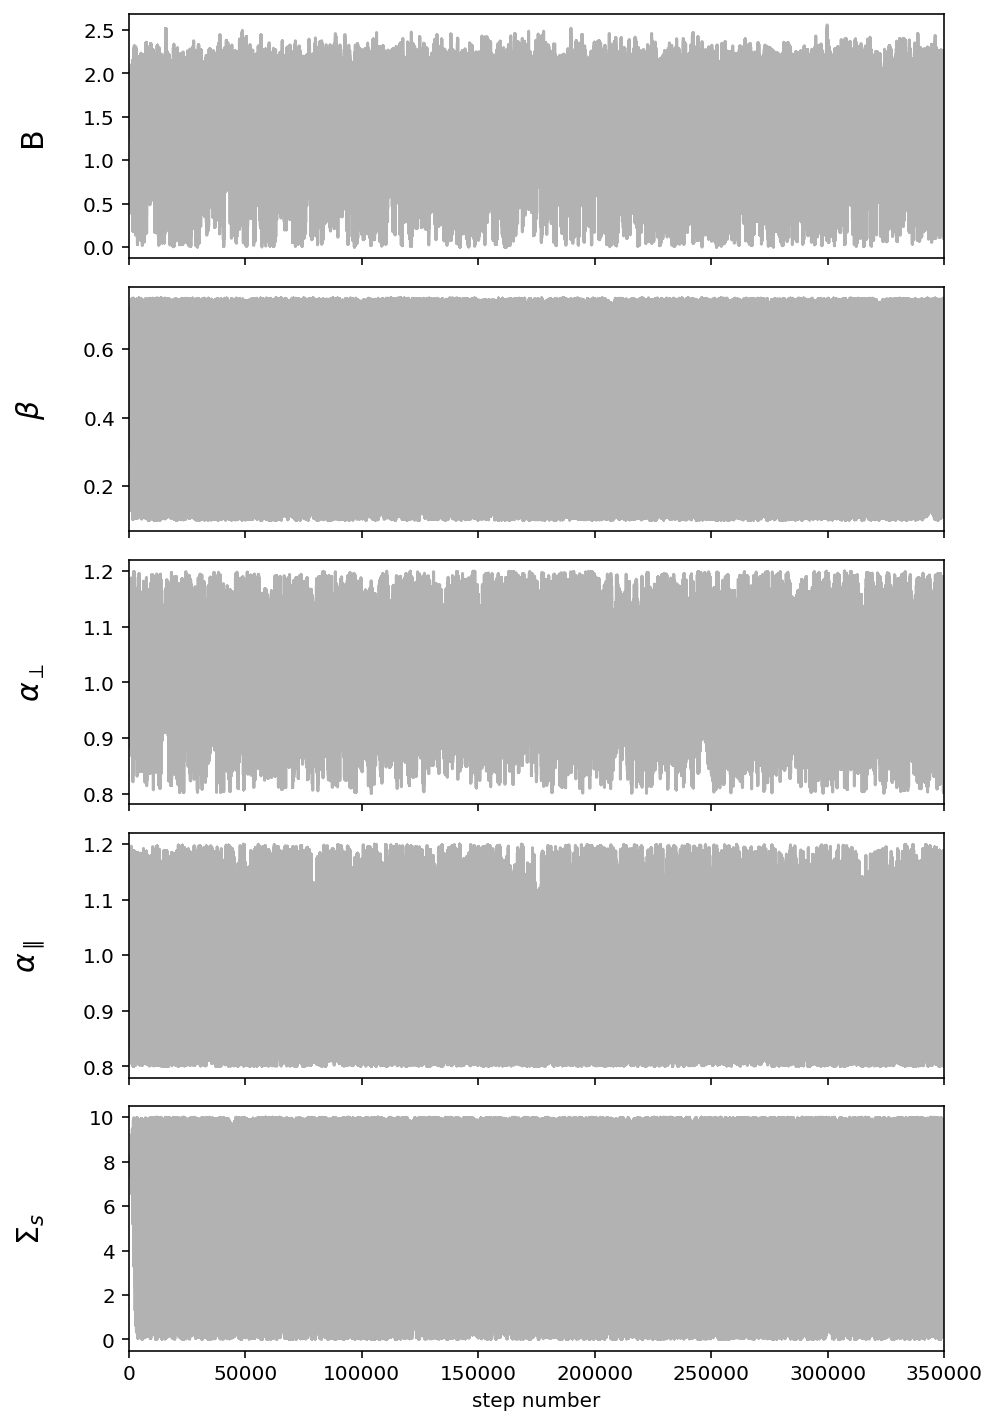

In [26]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(5, figsize=(7, 10), sharex=True)
labels=['B', r'$\beta$', r'$\alpha_\perp$', r'$\alpha_\parallel$', r'$\Sigma_s$']
for i in range(0,5):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");


#These are the emcee chains after the run.  
# See https://emcee.readthedocs.io/en/stable/tutorials/line/ for an example emcee fit
#The emcee paper: https://arxiv.org/abs/1202.3665

In [27]:
#discard (burn) a few times the autocorrelation time and thin by half
samples1 = reader.get_chain(discard = 200, flat =True, thin =40)
print(samples1.shape)

(8575, 5)


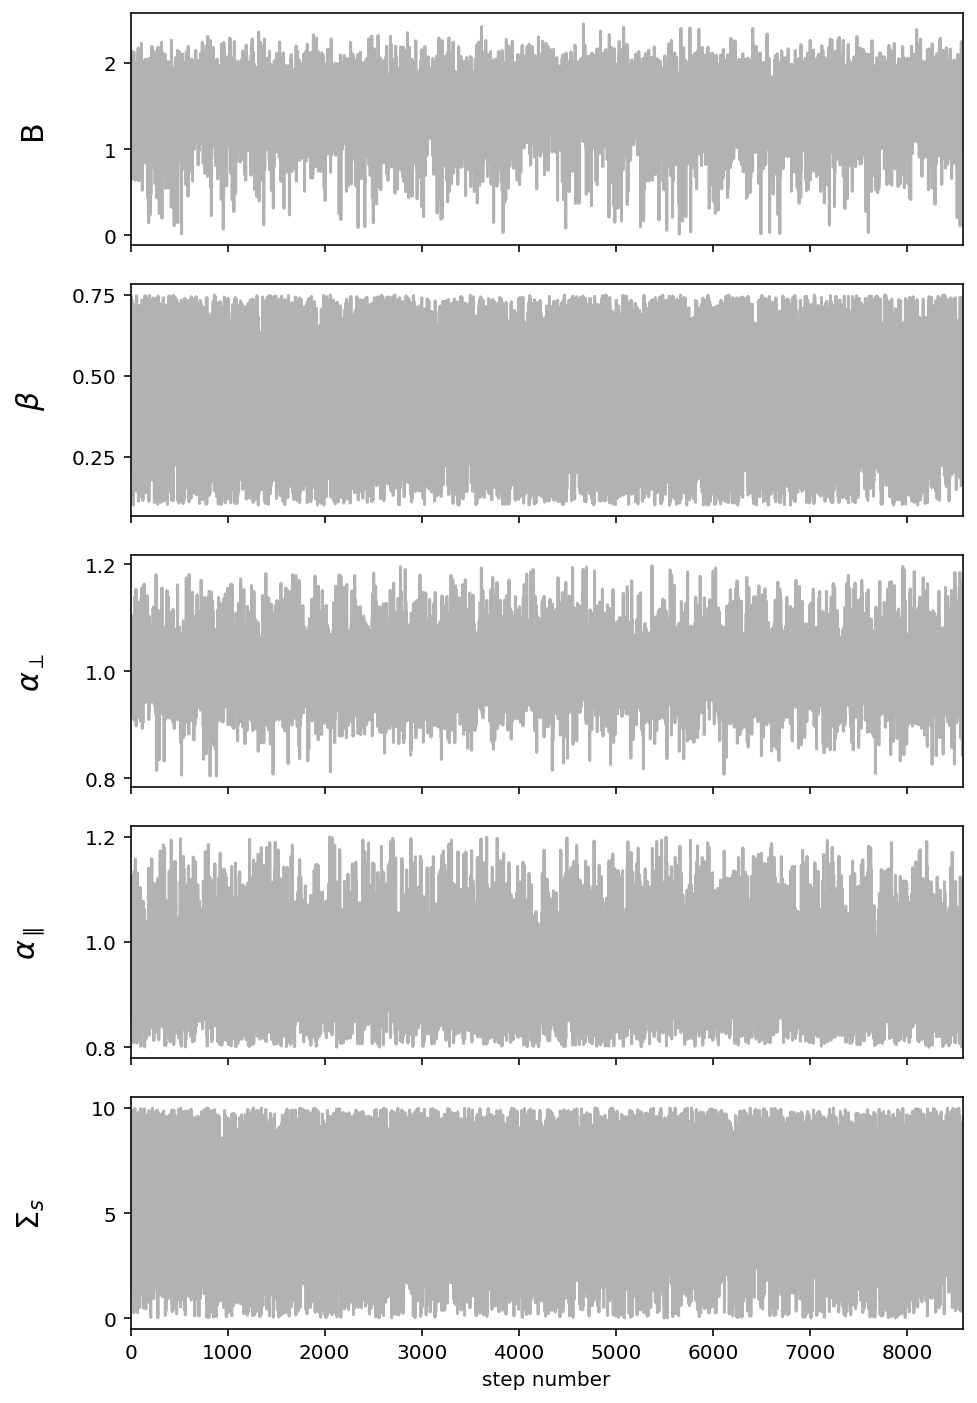

In [28]:
fig1, axes1 = plt.subplots(5, figsize=(7, 10), sharex=True)
#labels =["B", "beta", "sigs", 'a1', 'a2', 'a3', 'a4', 'a5', 'alpha_par', 'alpha_perp']
plt.rcParams.update({'font.size': 15})
labels=['B', r'$\beta$', r'$\alpha_\perp$', r'$\alpha_\parallel$', r'$\Sigma_s$']
for i in range(0,5):
    ax1 = axes1[i]
    ax1.plot(samples1[:, i], "k", alpha=0.3)
    ax1.set_xlim(0, len(samples1))
    #ax1.set_xlim(0, 4000)
    ax1.set_ylabel(labels[i],fontsize=15)
    ax1.yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel("step number");

#These are the chains after being "burned" and thinned 

In [29]:
import corner
plt.rcParams['figure.subplot.top'] = .95
plt.rcParams['figure.subplot.bottom'] = 0.05
plt.rcParams['figure.subplot.right'] = 1.
labels=['B', r'$\beta$', r'$\alpha_\perp$', r'$\alpha_\parallel$', r'$\Sigma_s$']
fig = corner.corner(samples1, labels=labels,label_kwargs={"fontsize": 18});
# Extract the axes
axes = np.array(fig.axes).reshape((5, 5))

#Loop over diagonal
for i in range(5):
    ax = axes[i,i]
    ax.tick_params(labelsize=13)

# Loop over the histograms
for yi in range(5):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.tick_params(labelsize=13)

        
#The corner plots of the chains. I take the best-fit alpha values to be the 50th percentile of the sample.

ModuleNotFoundError: No module named 'corner'